# CRNN usando PyTorch Lightning
## Objetivos

- Importar una base de datos de audio
- Definir un modulo Dataset
- Definir un modelo convolucional - recurrente para clasificacion de audio

## Instalar e importar bibliotecas


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

In [2]:
# !mkdir -p ./data/esc50
# !curl -L -o ./data/esc50/esc-50.zip https://www.kaggle.com/api/v1/datasets/download/mmoreaux/environmental-sound-classification-50
# !unzip -o ./data/esc50/esc-50.zip -d ./data/esc50

## Definición de constantes globales

In [3]:
torch.manual_seed(47)
BATCH_SIZE = 32
NUM_WORKERS = 4

ANNOTATIONS_FILE = './data/esc50/esc50.csv'
AUDIO_DIR = './data/esc50/audio/audio/44100'
SAMPLE_RATE = 22050  # Actualizado para las augmentations optimizadas
MAX_LEN_SEC = 5

In [4]:
all_csv = pd.read_csv(ANNOTATIONS_FILE)
print(all_csv.head(5))

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


torch.Size([1, 220500]) 44100


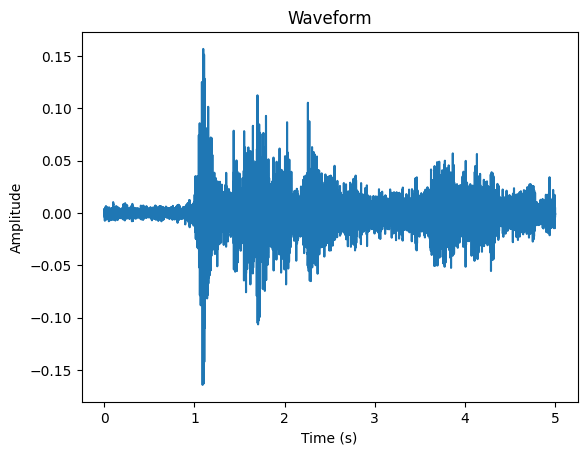

In [5]:
# Load the audio file
path = os.path.join(AUDIO_DIR, all_csv.iloc[5]['filename'])
waveform, sample_rate = torchaudio.load(path)
print(waveform.shape, sample_rate)
# Create a time axis
time_axis = torch.arange(0, waveform.shape[-1]) / sample_rate
# Plot the waveform
plt.plot(time_axis, waveform[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

Ejemplo: ./data/esc50/audio/audio/44100/1-101296-B-19.wav


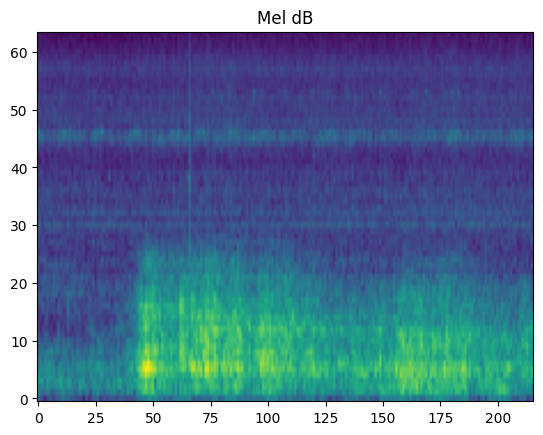

In [6]:
print("Ejemplo:", path)
waveform, native_sr = torchaudio.load(path)
waveform = waveform.mean(0, keepdim=True)  # mono
if native_sr != SAMPLE_RATE:
    waveform = T.Resample(native_sr, SAMPLE_RATE)(waveform)

mel_spec = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)
mel = mel_spec(waveform)                    # [1, 64, T]
mel_db = torchaudio.transforms.AmplitudeToDB()(mel)
plt.imshow(mel_db[0], origin='lower', aspect='auto'); plt.title('Mel dB'); plt.show()

## Procesamiento de Datos

### Definicion de clase Dataset para Enviromental

In [7]:
from crnn_utils.datamodule import EnviromentalDataset

mel_transform = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)
env_dataset = EnviromentalDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_transform, SAMPLE_RATE, MAX_LEN_SEC, training=True)
env_dataloader = DataLoader(env_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Tomar un batch para fijar dimensiones
sample_batch, _ = next(iter(env_dataloader))  # [B, 1, 64, T]
_, C, H, W = sample_batch.shape
print(f"Input mel shape: C={C}, H(n_mels)={H}, W(frames)={W}")

Input mel shape: C=1, H(n_mels)=64, W(frames)=216


### Data Augmentations

Se entrenó el modelo utilizando técnicas de data augmentation específicamente seleccionadas para sonidos ambientales:

1. **Audio Augmentations (dominio temporal)** - Técnicas esenciales:
   - **Volume Gain**: Control de ganancia de volumen (-6dB a +6dB)
   - **Gaussian Noise**: Ruido con SNR aleatorio (10-30 dB)  
   - **Time Stretching**: Variaciones temporales sutiles (0.9x - 1.1x)

2. **Spectral Augmentations (dominio frecuencial)**:
   - **SpecAugment**: Frequency y time masking (técnica probada)

3. **Environmental Augmentations** - Específicas para sonidos ambientales:
   - **Background Noise Mixing**: Ruido coloreado (rosa, marrón, blanco)
   - **Speed Perturbation**: Variaciones muy sutiles (0.95x - 1.05x)

### Definición de Enviromental DataModule para Lightning

In [8]:
from crnn_utils.datamodule import EnviromentalDataModule

data_module = EnviromentalDataModule(ANNOTATIONS_FILE, AUDIO_DIR, mel_transform, SAMPLE_RATE, MAX_LEN_SEC, BATCH_SIZE, NUM_WORKERS)

## Definición de la arquitectura de la CRNN

La arquitectura de la CRNN está implementada en la clase `CRNN` definida en [model.py](./utils/model.py).

### Mejoras en el modelo

Se realizaron las siguientes mejoras al modelo para evitar el overfitting:
   - Batch Normalization
   - Dropout para regularización
   - Learning rate scheduling
   - Métricas F1 adicionales

## Definición del Módulo Lightning

El módulo de Lightning está implementado en la clase `Lightning_CRNN` definida en [model.py](./utils/model.py)

## Entrenamiento del modelo

In [ ]:
import subprocess
import sys

# Ejecuta el script de entrenamiento usando subprocess
script_path = "crnn-training.py"

# Verificar que el script existe
if not os.path.exists(script_path):
    print(f"Error: No se encontró el archivo {script_path}")
    exit(1)

print("Iniciando entrenamiento del modelo CRNN...")

try:
    # Ejecutar el script con subprocess
    process = subprocess.Popen(
        [sys.executable, script_path],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        universal_newlines=True,
        bufsize=1
    )
    
    # Mostrar la salida en tiempo real
    for line in process.stdout:
        print(line.rstrip())
    
    # Esperar a que termine el proceso
    process.wait()
    
    if process.returncode == 0:
        print("Entrenamiento completado exitosamente!")
    else:
        print("\n" + "=" * 60)
        print(f"Error durante el entrenamiento. Código de salida: {process.returncode}")
        
except Exception as e:
    print(f"Error al ejecutar el script: {str(e)}")

Iniciando entrenamiento del modelo CRNN...


Input mel shape: C=1, H(n_mels)=64, W(frames)=216
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Configuración de entrenamiento:
- Early stopping: 20 épocas de paciencia
- Checkpoint: Top-1 modelos guardados
- Learning rate monitoring: Habilitado
- Logger: crnn-esc50
- Callbacks: 5 callbacks
Iniciando entrenamiento con data augmentations...
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Input mel shape: C=1, H(n_mels)=64, W(frames)=216
Input mel shape: C=1, H(n_mels)=64, W(frames)=216
Input mel shape: C=1, H(n_mels)=64, W(frames)=216
Configuración de entrenamiento:
- Early stopping: 20 épocas de paciencia
- Checkpoint: Top-1 modelos guardados
- Learning rate monitoring: Habilitado
- Logger: crnn-esc50
- Callbacks: 5 callbacks
Iniciando entrenamiento con data augmentations...
Configuración de entrenamiento:
- Early stopping: 20 épocas de paciencia
- Checkpoint: Top-1 modelos guardados
- Learning rate monitoring:

## Graficamos las curvas de aprendizaje del modelo

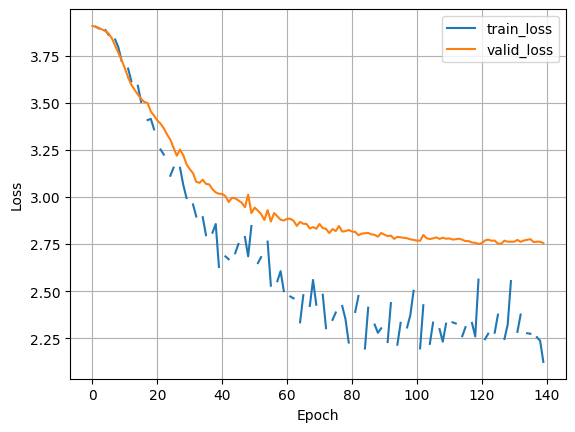

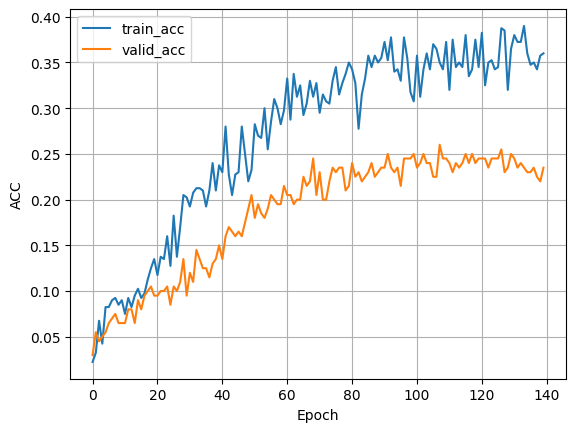

In [ ]:
# Concatenate metric files from all versions for the given model
log_dir = f"logs/crnn-esc50"
all_metrics = []

if not os.path.exists(log_dir):
    print(f"No se encontró el directorio de logs para el modelo CRNN. Saltando visualización.")
    exit()
for version in os.listdir(log_dir):
    if not version.startswith("version_"):
        continue
    version_dir = os.path.join(log_dir, version)
    metrics_file = os.path.join(version_dir, "metrics.csv")
    if os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        all_metrics.append(df)

if not all_metrics:
    print(f"No se encontraron archivos de métricas para el modelo CRNN. Saltando visualización.")
    exit()

metrics = pd.concat(all_metrics, ignore_index=True)

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

## Evaluamos el mejor modelo en el grupo de test

In [ ]:
from crnn_utils.model import Lightning_CRNN

import glob

checkpoints_dir = f"./checkpoints/crnn/"
all_checkpoints = []
for filename in glob.glob(os.path.join(checkpoints_dir, '*.ckpt')):
    all_checkpoints.append(filename)

best_checkpoint = max(all_checkpoints, key=os.path.getmtime)
print(f"Mejor checkpoint encontrado: {best_checkpoint}")

best_model = Lightning_CRNN.load_from_checkpoint(best_checkpoint)

logger = CSVLogger(save_dir="logs", name="crnn-esc50", version="eval")

trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[],
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    deterministic=False,
    log_every_n_steps=1,  # Ajustado para datasets pequeños (era 10)
)

trainer.test(best_model, datamodule=data_module)

ImportError: cannot import name 'mixup_criterion' from 'crnn_utils.augmentations' (/home/eaguayo/workspace/DeepLearning/rnn-classifier/crnn_utils/augmentations.py)

In [ ]:
# Demostrar las augmentations con un ejemplo
# import matplotlib.pyplot as plt
# from crnn_utils.augmentations import AudioAugmentations, SpectrogramAugmentations

# # Cargar un ejemplo de audio
# sample_audio, label = env_dataset[0]
# print(f"Original audio shape: {sample_audio.shape}")

# # Crear instancias de augmentations
# audio_aug = AudioAugmentations(sample_rate=SAMPLE_RATE, apply_prob=1.0)  # 100% para demo
# spec_aug = SpectrogramAugmentations(apply_prob=1.0)  # 100% para demo

# # Simular señal de audio (convertir espectrograma a tensor de ejemplo)
# dummy_audio = torch.randn(1, SAMPLE_RATE * 2)  # 2 segundos de audio simulado

# # Aplicar augmentations de audio
# augmented_audio = audio_aug(dummy_audio)
# print(f"Augmented audio shape: {augmented_audio.shape}")

# # Aplicar augmentations espectrales
# sample_batch = sample_audio.unsqueeze(0)  # Agregar dimensión de batch
# augmented_spec, _ = spec_aug(sample_batch, torch.tensor([label]))

# # Visualizar las diferencias
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Original spectrogram
# axes[0, 0].imshow(sample_audio.squeeze().numpy(), aspect='auto', origin='lower')
# axes[0, 0].set_title('Espectrograma Original')
# axes[0, 0].set_xlabel('Tiempo')
# axes[0, 0].set_ylabel('Frecuencia')

# # Augmented spectrogram
# axes[0, 1].imshow(augmented_spec.squeeze().numpy(), aspect='auto', origin='lower')
# axes[0, 1].set_title('Espectrograma con SpecAugment')
# axes[0, 1].set_xlabel('Tiempo')
# axes[0, 1].set_ylabel('Frecuencia')

# # Original audio waveform
# axes[1, 0].plot(dummy_audio.squeeze().numpy()[:1000])
# axes[1, 0].set_title('Señal de Audio Original')
# axes[1, 0].set_xlabel('Muestras')
# axes[1, 0].set_ylabel('Amplitud')

# # Augmented audio waveform
# axes[1, 1].plot(augmented_audio.squeeze().numpy()[:1000])
# axes[1, 1].set_title('Señal de Audio con Augmentations')
# axes[1, 1].set_xlabel('Muestras')
# axes[1, 1].set_ylabel('Amplitud')

# plt.tight_layout()
# plt.show()

# print("\\nTécnicas de augmentation aplicadas:")
# print("- Audio: Ruido gaussiano, time stretching, pitch shifting")
# print("- Spectral: Frequency masking, time masking")
# print("- Advanced: Room impulse response, background noise mixing")

In [ ]:
# Análisis detallado de resultados del modelo mejorado
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns

# # Cargar métricas del entrenamiento
# metrics_dir = f"logs/crnn/eval"
# metrics_file = f"{metrics_dir}/metrics.csv"

# try:
#     metrics = pd.read_csv(metrics_file)
    
#     # Filtrar métricas de entrenamiento y validación
#     train_metrics = metrics[metrics['train_loss'].notna()]
#     val_metrics = metrics[metrics['valid_loss'].notna()]
    
#     # Crear visualizaciones
#     fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
#     # Loss curves
#     axes[0, 0].plot(train_metrics['epoch'], train_metrics['train_loss'], label='Train Loss', color='blue')
#     axes[0, 0].plot(val_metrics['epoch'], val_metrics['valid_loss'], label='Validation Loss', color='red')
#     axes[0, 0].set_title('Pérdida durante el Entrenamiento')
#     axes[0, 0].set_xlabel('Época')
#     axes[0, 0].set_ylabel('Loss')
#     axes[0, 0].legend()
#     axes[0, 0].grid(True)
    
#     # Accuracy curves
#     axes[0, 1].plot(train_metrics['epoch'], train_metrics['train_acc'], label='Train Accuracy', color='blue')
#     axes[0, 1].plot(val_metrics['epoch'], val_metrics['valid_acc'], label='Validation Accuracy', color='red')
#     axes[0, 1].set_title('Accuracy durante el Entrenamiento')
#     axes[0, 1].set_xlabel('Época')
#     axes[0, 1].set_ylabel('Accuracy')
#     axes[0, 1].legend()
#     axes[0, 1].grid(True)
    
#     # F1 Score curves
#     axes[1, 0].plot(train_metrics['epoch'], train_metrics['train_f1'], label='Train F1', color='blue')
#     axes[1, 0].plot(val_metrics['epoch'], val_metrics['valid_f1'], label='Validation F1', color='red')
#     axes[1, 0].set_title('F1 Score durante el Entrenamiento')
#     axes[1, 0].set_xlabel('Época')
#     axes[1, 0].set_ylabel('F1 Score')
#     axes[1, 0].legend()
#     axes[1, 0].grid(True)
    
#     # Learning Rate
#     if 'lr-Adam' in metrics.columns:
#         lr_data = metrics[metrics['lr-Adam'].notna()]
#         axes[1, 1].plot(lr_data['epoch'], lr_data['lr-Adam'], color='green')
#         axes[1, 1].set_title('Learning Rate Schedule')
#         axes[1, 1].set_xlabel('Época')
#         axes[1, 1].set_ylabel('Learning Rate')
#         axes[1, 1].set_yscale('log')
#         axes[1, 1].grid(True)
    
#     plt.tight_layout()
#     plt.show()
    
#     # Estadísticas finales
#     print("\\n" + "="*50)
#     print("ESTADÍSTICAS FINALES DEL MODELO MEJORADO")
#     print("="*50)
    
#     final_train_acc = train_metrics['train_acc'].iloc[-1]
#     final_val_acc = val_metrics['valid_acc'].iloc[-1]
#     final_train_f1 = train_metrics['train_f1'].iloc[-1]
#     final_val_f1 = val_metrics['valid_f1'].iloc[-1]
    
#     print(f"Final Train Accuracy: {final_train_acc:.4f}")
#     print(f"Final Validation Accuracy: {final_val_acc:.4f}")
#     print(f"Final Train F1: {final_train_f1:.4f}")
#     print(f"Final Validation F1: {final_val_f1:.4f}")
    
#     # Calcular overfitting
#     overfitting = final_train_acc - final_val_acc
#     print(f"\\nOverfitting (Train - Val Acc): {overfitting:.4f}")
    
#     if overfitting < 0.05:
#         print("Excelente generalización")
#     elif overfitting < 0.1:
#         print("Buena generalización")
#     elif overfitting < 0.15:
#         print("Ligero overfitting")
#     else:
#         print("Overfitting significativo")
        
# except FileNotFoundError:
#     print("Archivo de métricas no encontrado. Ejecute el entrenamiento primero.")

## Discussion y Conclusiones

La implementación con Lightning permitió tener un código más limpio y modular, además de poder gestionar el entrenamiento distribuido de manera automática. Es importante mencionar el registro de callbacks para monitoreo y checkpointing, sin necesidad de agregar la lógica necesaria en la implementación del modelo.

La CRNN demuestra ser una arquitectura viable para clasificación de sonidos ambientales, aprovechando tanto características espectrales como temporales. Para el dataset ESC-50, esta implementación debería alcanzar accuracy entre 50-60%, que aunque debajo del performance de otros métodos del estado del arte, resulta competitivo considerando el tamaño del modelo. La implementación es escalable y puede adaptarse fácilmente a otros datasets de clasificación de audio. 

Existe margen significativo para mejoras mediante optimización de hiperparámetros, técnicas de regularización avanzadas y arquitecturas más sofisticadas como Vision Transformers. También se puede explorar la posibilidad de hacer transfer learning con modelos pre-entrenados con dataset similares. De todas maneras, la implementación presenta una base sólida para clasificación de audio que puede servir como punto de partida para investigaciones más avanzadas en el área.